In [32]:
import os
import pandas as pd
from fastbook import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from dtreeviz.trees import *
import sklearn

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

traindf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/train.csv',low_memory=False)
testdf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/test.csv',low_memory= False)
traindf.dropna(inplace = True)



In [33]:
def split_group_number(df):
    df['Group'] = df['PassengerId'].apply(lambda x: x.split("_")[0] if pd.notna(x) else pd.NA)
    df['GroupNumber'] = df['PassengerId'].apply(lambda x: x.split("_")[1] if pd.notna(x) else pd.NA)
    return df
traindf = split_group_number(traindf)
testdf = split_group_number(testdf)

In [34]:
def group_size(row):
    group = traindf[traindf.Group == row.Group]
    return len(group)


traindf['GroupSize'] = traindf.apply(group_size, axis = 1)
testdf['GroupSize'] = testdf.apply(group_size,axis = 1)

/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/pyth

decision tree prediction 0.79333838001514


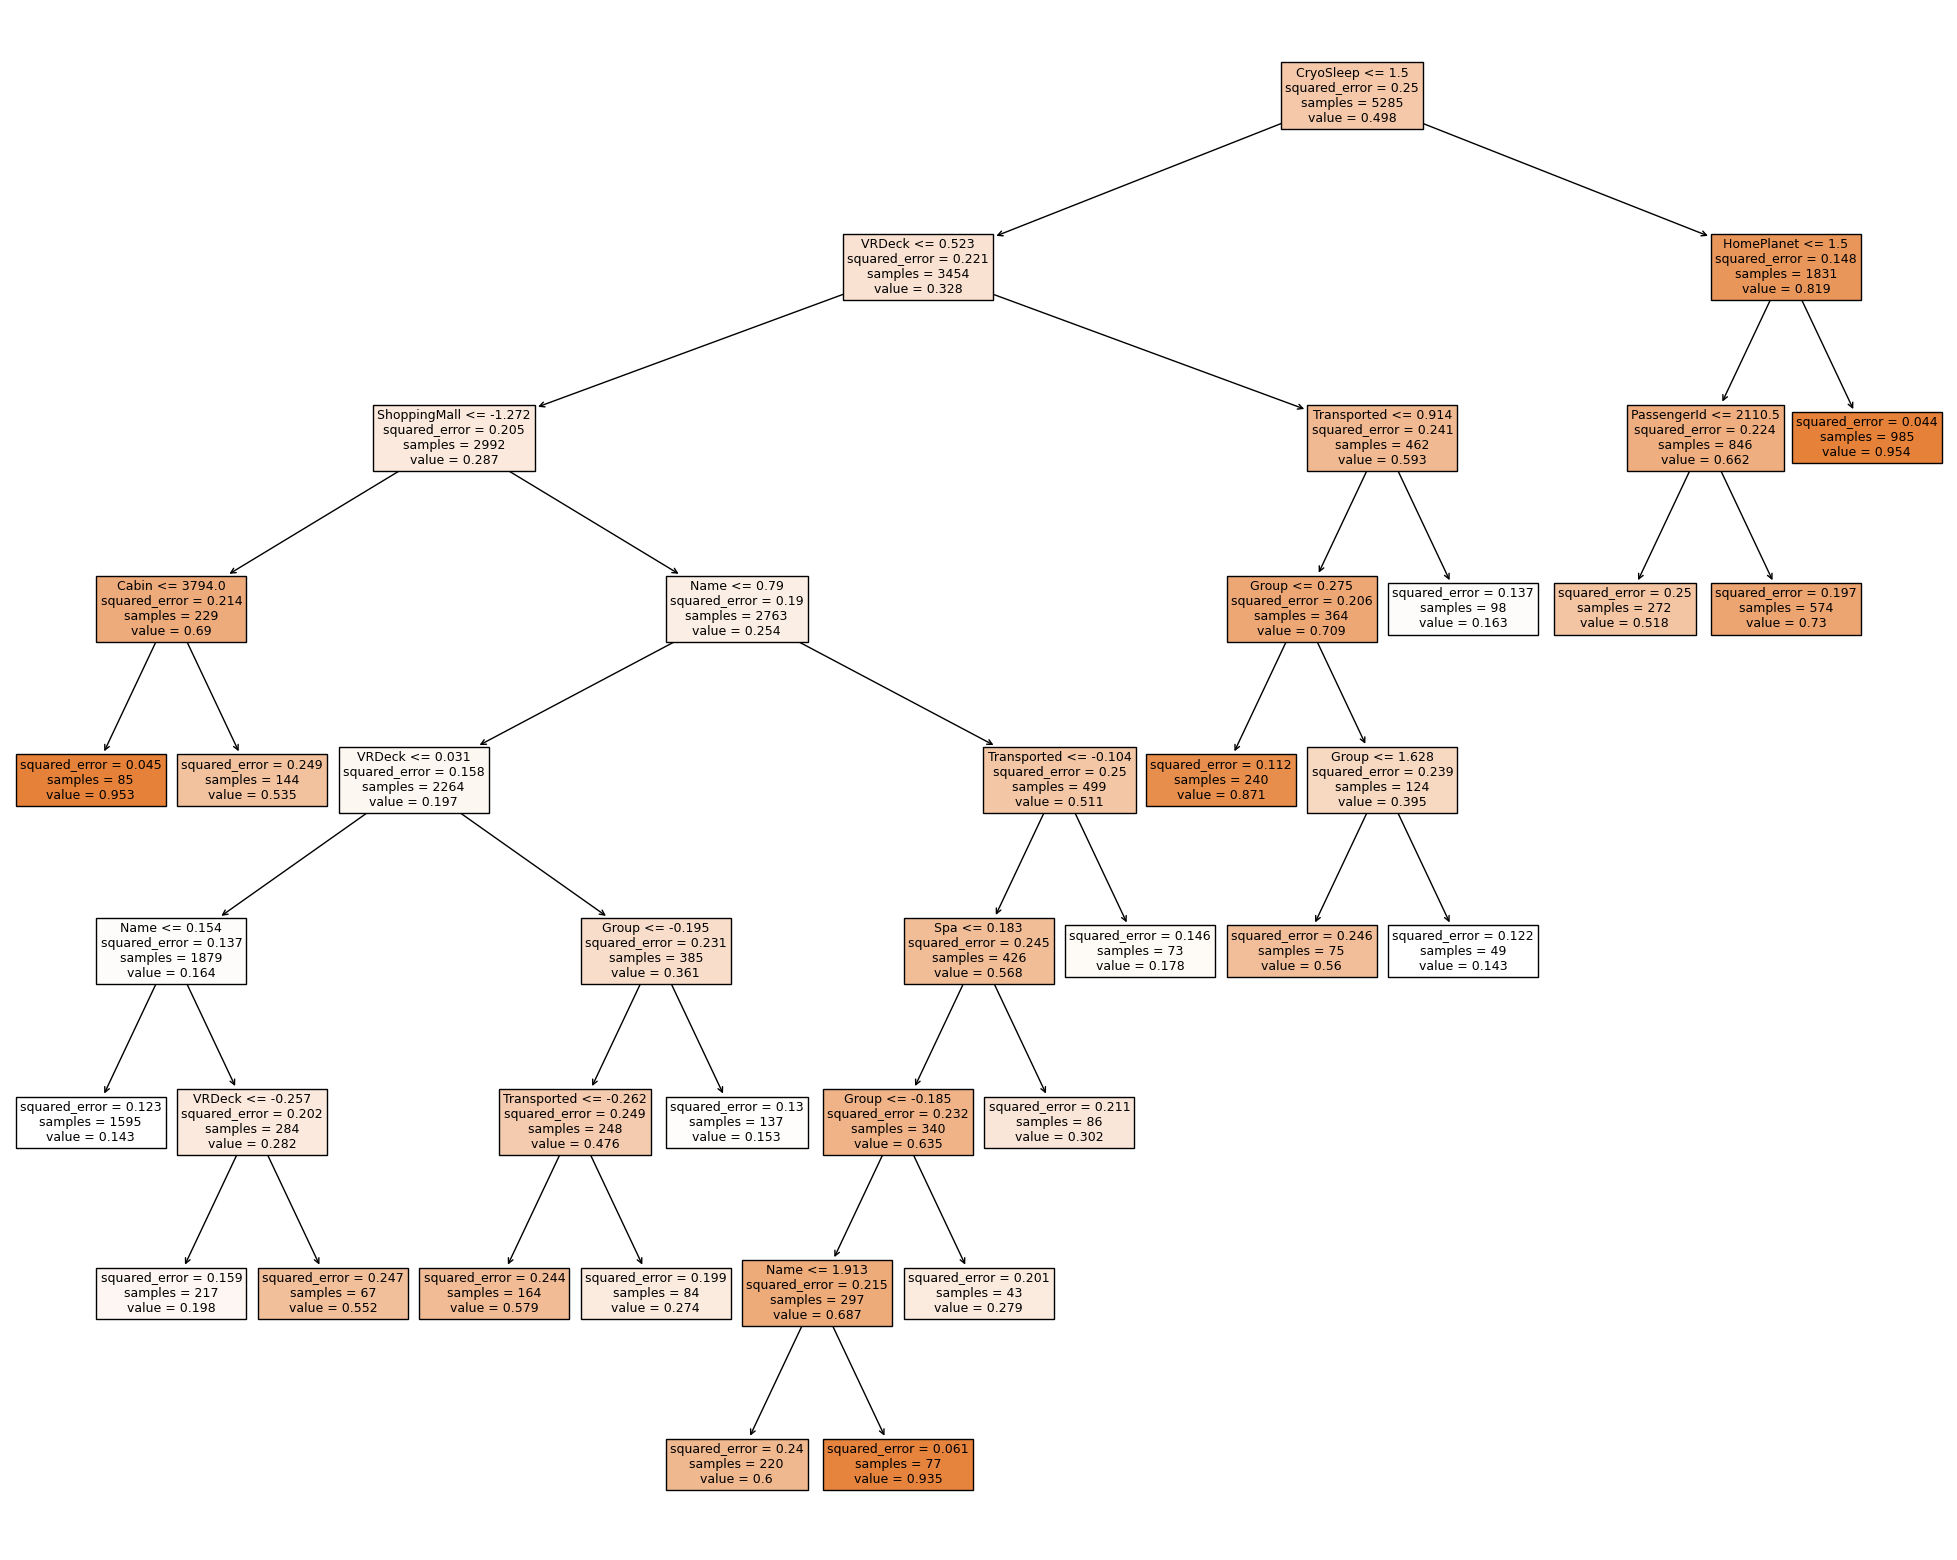

In [35]:
splits = RandomSplitter(seed = 1)(range_of(traindf))
dep_var = 'Transported'
procs = [Categorify,FillMissing,Normalize]
cont,cat = cont_cat_split(traindf, 1, dep_var=dep_var)
to = TabularPandas(traindf, procs, cat, cont, y_names=dep_var,splits = splits)



xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=20)
m.fit(xs, y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m,
                   feature_names= traindf.columns,
                   filled=True)

print('decision tree prediction',((m.predict(valid_xs) > 0.5) == valid_y).sum() / len(valid_y))


In [36]:


m = RandomForestClassifier(n_estimators= 100, max_leaf_nodes= 50)
m.fit(xs, y)
preds = m.predict(valid_xs)
print("mae",mean_absolute_error(valid_y, preds))
print('preds', (preds == valid_y).sum() /len(valid_y))



mae 0.19530658591975775
preds 0.8046934140802422


In [37]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
print(fi[:30])

            cols       imp
2      CryoSleep  0.202062
13           Spa  0.150308
14        VRDeck  0.124143
10   RoomService  0.118120
11     FoodCourt  0.100868
12  ShoppingMall  0.081598
3          Cabin  0.073544
1     HomePlanet  0.044370
9            Age  0.030237
7          Group  0.019582
0    PassengerId  0.018714
6           Name  0.018163
4    Destination  0.008401
15     GroupSize  0.005307
8    GroupNumber  0.004051
5            VIP  0.000531
